In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:

# Step 1: Load and preprocess the Flowers dataset
dataset_name = "tf_flowers"
(train_ds, test_ds), dataset_info = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

num_classes = dataset_info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes

5

In [ ]:
dataset_info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
# Resize and normalize images
input_shape = (224, 224)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, input_shape) / 255.0, y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, input_shape) / 255.0, y))

# Convert datasets to numpy arrays for data augmentation
train_images, train_labels = [], []
test_images, test_labels = [], []

for image, label in train_ds:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

for image, label in test_ds:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_images.shape

(2936, 224, 224, 3)

In [ ]:
test_images.shape

(734, 224, 224, 3)

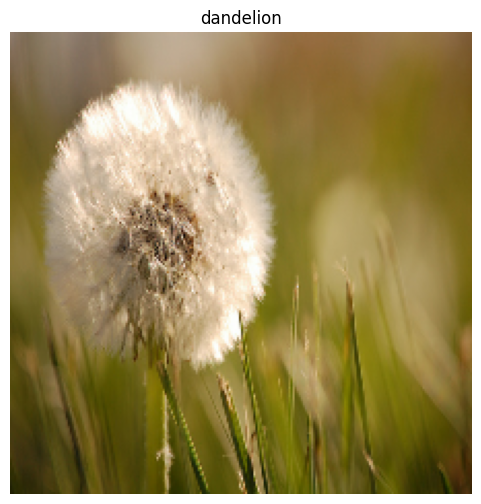

In [ ]:
# Predict and visualize one random test image
random_index = random.randint(0, len(train_images) - 1)
image, actual_label = train_images[random_index], train_labels[random_index]

# Get class names from dataset_info
class_names = dataset_info.features['label'].names

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"{class_names[actual_label]}")
plt.axis("off")
plt.show()


In [ ]:

# Step 2: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(train_images)  # Fit the data generator on the numpy arrays

## Train the VGG16 pretrained model by freezing Convolution layers

In [ ]:
# Step 3: Load the pre-trained VGG16 model and modify it for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


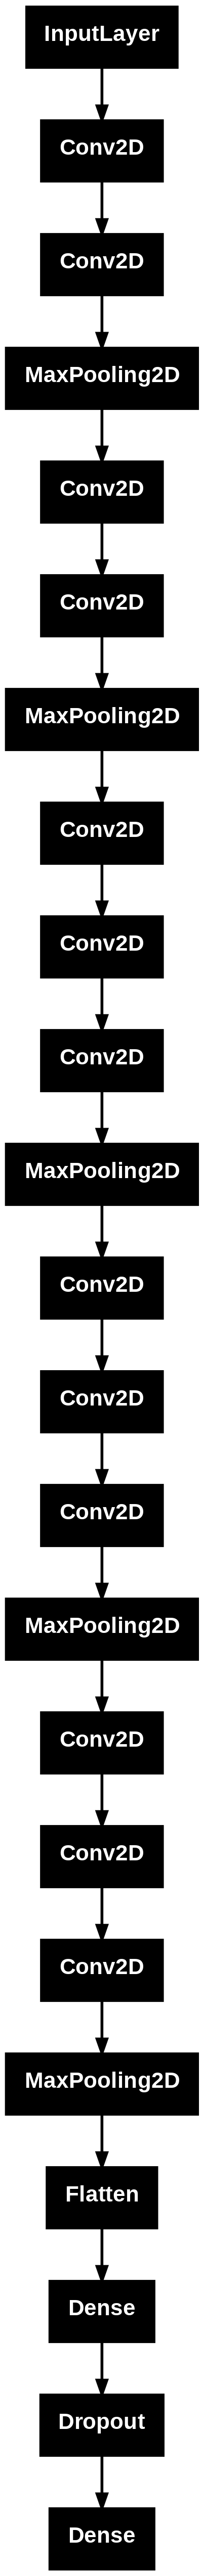

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

# Step 4: Train the model
epochs = 50
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=int(len(train_images) / batch_size),
                    epochs=epochs,
                    validation_data=(test_images, test_labels),callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 84s 732ms/step - accuracy: 0.4745 - loss: 1.3642 - val_accuracy: 0.7616 - val_loss: 0.6472
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.6875 - loss: 0.8011

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6875 - loss: 0.8011 - val_accuracy: 0.7629 - val_loss: 0.6336
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 381ms/step - accuracy: 0.7299 - loss: 0.7212 - val_accuracy: 0.8011 - val_loss: 0.5445
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8438 - loss: 0.4647 - val_accuracy: 0.7943 - val_loss: 0.5539
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.8126 - loss: 0.5810 - val_accuracy: 0.8365 - val_loss: 0.4728
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8438 - loss: 0.4810 - val_accuracy: 0.8324 - val_loss: 0.4723
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.8022 - loss: 0.5426 - val_accuracy: 0.8365 - val_loss: 0.4463
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9375 - loss: 0.2672 - val_accuracy: 0.8379 - val_loss: 0.4549
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.8216 - loss: 0.4808 - val_accuracy: 0.8338 - val_

23/23 - 3s - 132ms/step - accuracy: 0.8324 - loss: 0.4746
Test accuracy: 83.24%


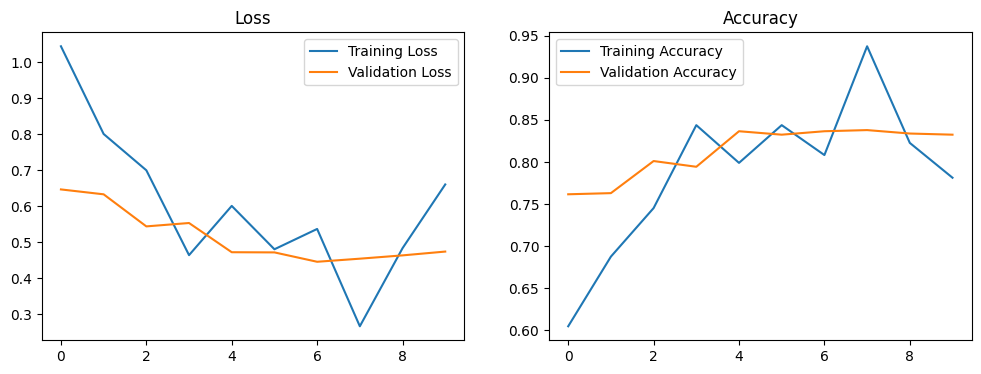

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


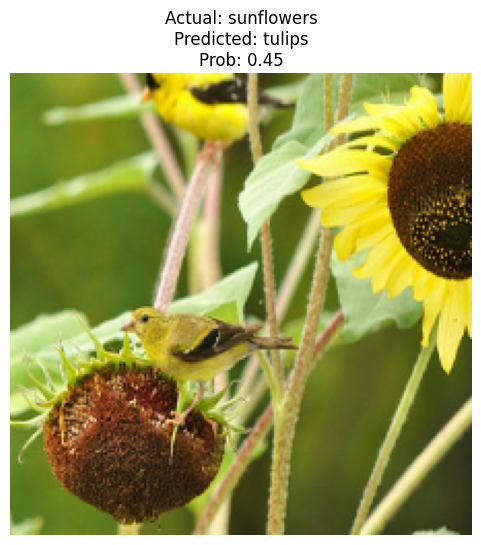

In [ ]:
# Predict and visualize one random test image
random_index = random.randint(0, len(test_images) - 1)
image, actual_label = test_images[random_index], test_labels[random_index]

# Reshape the image for prediction (VGG16 input shape)
image = np.expand_dims(image, axis=0)

# Predict the class probabilities
predicted_probs = model.predict(image)[0]
predicted_label = np.argmax(predicted_probs)

# Get class names from dataset_info
class_names = dataset_info.features['label'].names

plt.figure(figsize=(6, 6))
plt.imshow(image[0])
plt.title(f"Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}\nProb: {predicted_probs[predicted_label]:.2f}")
plt.axis("off")
plt.show()


In [ ]:
stop here

## Training all the layers with imagenet weights as initial weights

In [ ]:

# Step 3: Load the pre-trained VGG16 model and modify it for transfer learning
Full_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers on top of the base model
x = Flatten()(Full_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
# Create the transfer learning model
New_model = Model(inputs=Full_model.input, outputs=output)


New_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
New_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 27,562,821 (105.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Step 4: Train the model
epochs = 50
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_new = New_model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=int(len(train_images) / batch_size),
                    epochs=epochs,
                    validation_data=(test_images, test_labels),callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 131s 948ms/step - accuracy: 0.3249 - loss: 1.5819 - val_accuracy: 0.6022 - val_loss: 0.9980
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 44s 494ms/step - accuracy: 0.6250 - loss: 0.9887

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6250 - loss: 0.9887 - val_accuracy: 0.5899 - val_loss: 1.0147
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 63s 573ms/step - accuracy: 0.5823 - loss: 1.0205 - val_accuracy: 0.6866 - val_loss: 0.8373
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7500 - loss: 0.6284 - val_accuracy: 0.6649 - val_loss: 0.9191
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 78s 572ms/step - accuracy: 0.7214 - loss: 0.7202 - val_accuracy: 0.8106 - val_loss: 0.5092
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7812 - loss: 0.5662 - val_accuracy: 0.8147 - val_loss: 0.4985
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 568ms/step - accuracy: 0.7797 - loss: 0.5584 - val_accuracy: 0.7766 - val_loss: 0.5860
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8750 - loss: 0.3758 - val_accuracy: 0.7929 - val_loss: 0.5505
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 565ms/step - accuracy: 0.8094 - loss: 0.4783 - val_accuracy: 0.8706 - val_

In [ ]:
# New_model.summary()

23/23 - 3s - 134ms/step - accuracy: 0.8583 - loss: 0.3879
Test accuracy: 85.83%


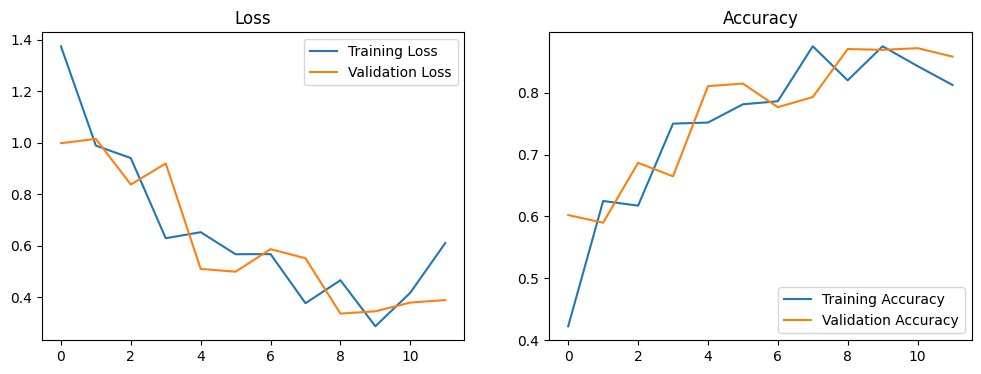

In [ ]:
# Evaluate the model
test_loss, test_acc = New_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


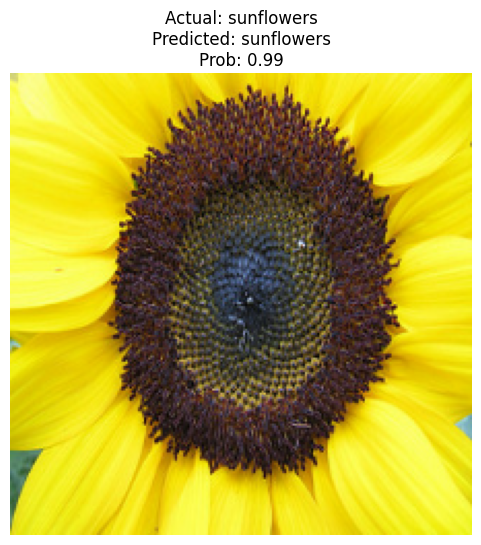

In [ ]:
# Predict and visualize one random test image
random_index = random.randint(0, len(test_images) - 1)
image, actual_label = test_images[random_index], test_labels[random_index]

# Reshape the image for prediction (VGG16 input shape)
image = np.expand_dims(image, axis=0)

# Predict the class probabilities
predicted_probs = New_model.predict(image)[0]
predicted_label = np.argmax(predicted_probs)

# Get class names from dataset_info
class_names = dataset_info.features['label'].names

plt.figure(figsize=(6, 6))
plt.imshow(image[0])
plt.title(f"Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}\nProb: {predicted_probs[predicted_label]:.2f}")
plt.axis("off")
plt.show()

## Train without using Imagenet Weights

In [ ]:

# Step 3: Load the pre-trained VGG16 model and modify it for transfer learning
Full_model = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers on top of the base model
x = Flatten()(Full_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
# Create the transfer learning model
New_model_1 = Model(inputs=Full_model.input, outputs=output)


New_model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
New_model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 27,562,821 (105.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Train the model
epochs = 50
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_new_1 = New_model_1.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=int(len(train_images) / batch_size),
                    epochs=epochs,
                    validation_data=(test_images, test_labels),callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 65s 607ms/step - accuracy: 0.2273 - loss: 1.6026 - val_accuracy: 0.2725 - val_loss: 1.4721
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 42s 474ms/step - accuracy: 0.1875 - loss: 1.5514

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1875 - loss: 1.5514 - val_accuracy: 0.2738 - val_loss: 1.4705
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 68s 556ms/step - accuracy: 0.3452 - loss: 1.4248 - val_accuracy: 0.4114 - val_loss: 1.3279
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4375 - loss: 1.3953 - val_accuracy: 0.4074 - val_loss: 1.3100
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.4000 - loss: 1.3106 - val_accuracy: 0.4796 - val_loss: 1.2898
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5000 - loss: 1.3101 - val_accuracy: 0.4768 - val_loss: 1.2948
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 575ms/step - accuracy: 0.4703 - loss: 1.2515 - val_accuracy: 0.5204 - val_loss: 1.1305
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4375 - loss: 1.3157 - val_accuracy: 0.5163 - val_loss: 1.1275
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 79s 576ms/step - accuracy: 0.5308 - loss: 1.1250 - val_accuracy: 0.5627 - val_

23/23 - 3s - 127ms/step - accuracy: 0.7384 - loss: 0.7031
Test accuracy: 73.84%


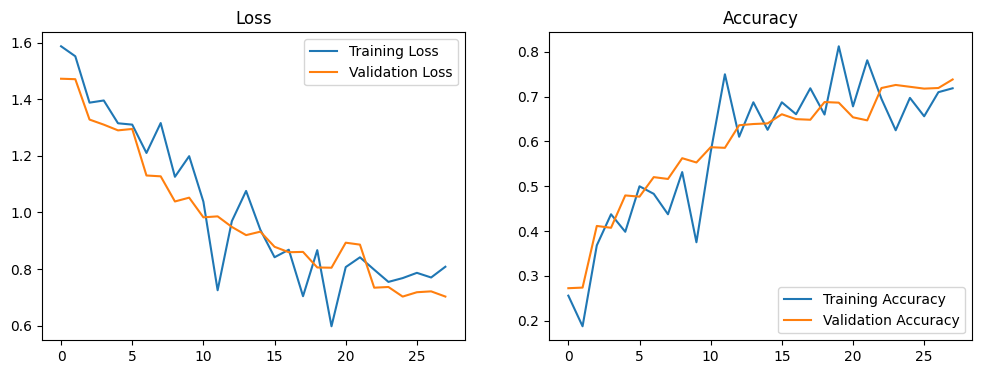

In [ ]:
# Evaluate the model
test_loss, test_acc = New_model_1.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_new_1.history['loss'], label='Training Loss')
plt.plot(history_new_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history_new_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


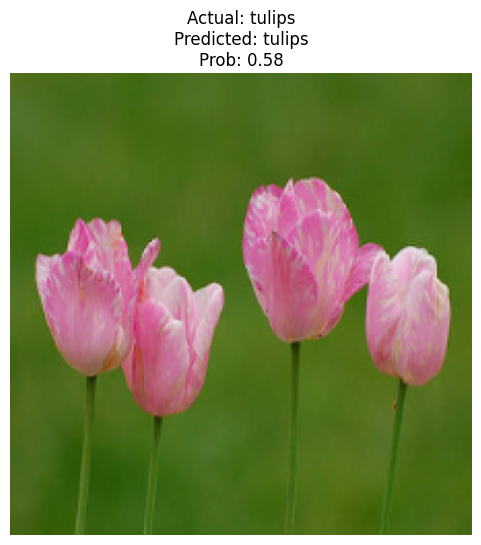

In [ ]:
# Predict and visualize one random test image
random_index = random.randint(0, len(test_images) - 1)
image, actual_label = test_images[random_index], test_labels[random_index]

# Reshape the image for prediction (VGG16 input shape)
image = np.expand_dims(image, axis=0)

# Predict the class probabilities
predicted_probs = New_model_1.predict(image)[0]
predicted_label = np.argmax(predicted_probs)

# Get class names from dataset_info
class_names = dataset_info.features['label'].names

plt.figure(figsize=(6, 6))
plt.imshow(image[0])
plt.title(f"Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}\nProb: {predicted_probs[predicted_label]:.2f}")
plt.axis("off")
plt.show()